<a href="https://colab.research.google.com/github/HowonRyu/ConfidenceSet/blob/main/example/Independent_Studies_2023Winter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import Normalize
import random
import sys
import os
import math
import scipy.stats
from tabulate import tabulate

#!rm -rf ConfSets
#!git clone https://github.com/TomMaullin/ConfSets.git
#sys.path.append('/content/ConfSets/lib/')
#from generateData import *
#from boundary import *

!pip install git+https://github.com/HowonRyu/ConfidenceSet.git
from confidenceset.functions import *

%load_ext autoreload
%autoreload 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/HowonRyu/ConfidenceSet.git to /tmp/pip-req-build-db_wyxyy
  Running command git clone --filter=blob:none --quiet https://github.com/HowonRyu/ConfidenceSet.git /tmp/pip-req-build-db_wyxyy
  Resolved https://github.com/HowonRyu/ConfidenceSet.git to commit 2b63c18ee35c5a159184e4adee41c661fd35f8c4
  Preparing metadata (setup.py) ... done
  Created wheel for confidenceset: filename=confidenceset-0.0.2-py3-none-any.whl size=10194 sha256=6666570a4aa102c1f151e9ccb921379ee39165701a0f6f8e0d69aaac55ec7df9
  Stored in directory: /tmp/pip-ephem-wheel-cache-fih9dbqu/wheels/f9/19/5b/cdc93bc4e6c6cb860f4b27d4854d2fd2baf458d5d896f8d4ee
Successfully built confidenceset


# FDR Confidence Set



\begin{array}{|c|c|} \hline
 & N & P &  \\ \hline
H_0 & TN & FP & m_0 \\
H_1 & FN & TP & m-m_0 \\ \hline
 & m-R & R & m \\ \hline
\end{array}


**Family Wise Error Rate (FWER)**
*   $FWER = P(FP \ge 1 | H_0)$
*   In multiple testing, use Bonferroni to control for: $FWER <\frac{\alpha}{m}$



**False Discovery Rate (FDR)**

*   $FDR = E(\frac{FP}{R} | R>0)P(R>0) = E \frac{FP}{\max(1,R)} $
*  ((If you can add BH proof))

## Signals

Different settings of image size and variance

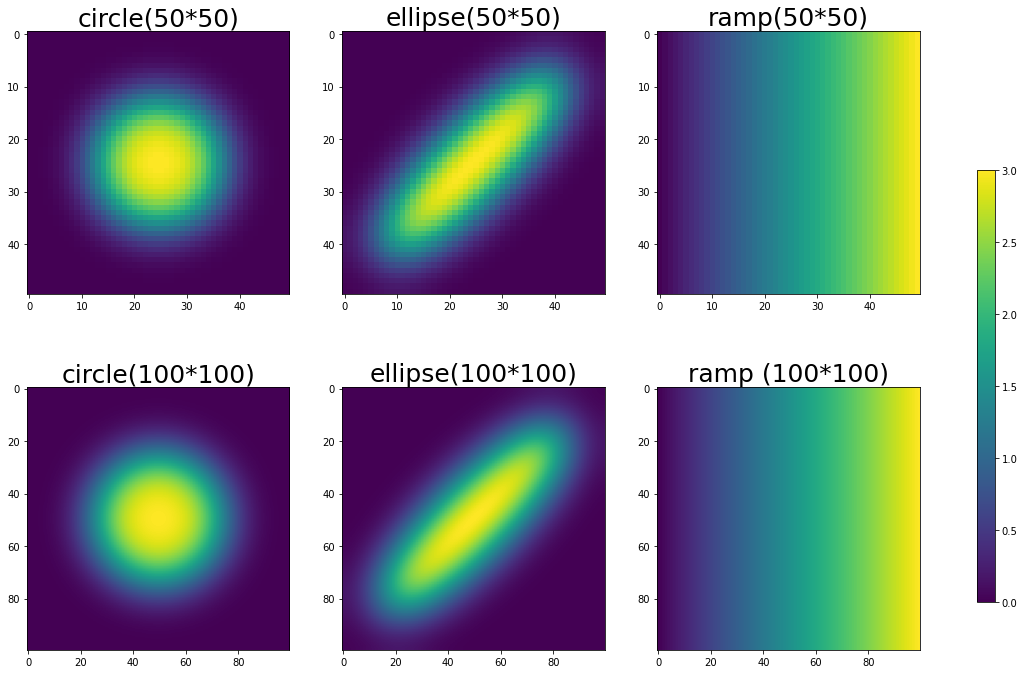

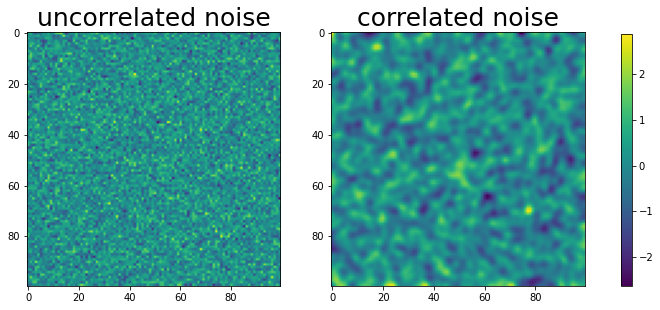

In [2]:
#settings
dim_100 = (80,100,100)
dim_50 = (80, 50, 50)
std = 3
mag = 3
r = 0.5
f50 = 10
f100 = 10*2

spec_cir_50 = {'a':r, 'b':r, 'std':std,'mag':mag, 'fwhm_noise':0, 'fwhm_signal':f50}
spec_elp_50 = {'a':r*2, 'b':r*0.5, 'std':std,'mag':mag, 'fwhm_noise':0, 'fwhm_signal':f50}
spec_ramp_50 = {'direction':1, 'std':std,'mag':(0,3), 'fwhm_noise':0}
spec_cir_50_smth = {'a':r, 'b':r, 'std':std, 'mag':mag, 'fwhm_noise':3/2, 'fwhm_signal':f50}
spec_elp_50_smth = {'a':r*2, 'b':r*0.5, 'std':std,'mag':mag, 'fwhm_noise':3/2, 'fwhm_signal':f50}
spec_ramp_50_smth = {'direction':1, 'std':std, 'mag':(0,3), 'fwhm_noise':3/2}


spec_cir_100 = {'a':r, 'b':r, 'std':std,'mag':mag, 'fwhm_noise':0, 'fwhm_signal':f100}
spec_elp_100 = {'a':r*2, 'b':r*0.5, 'std':std,'mag':mag, 'fwhm_noise':0, 'fwhm_signal':f100}
spec_ramp_100 = {'direction':1, 'std':std,'mag':(0,3), 'fwhm_noise':0}
spec_cir_100_smth = {'a':r, 'b':r, 'std':std, 'mag':mag, 'fwhm_noise':3, 'fwhm_signal':f100}
spec_elp_100_smth = {'a':r*2, 'b':r*0.5, 'std':std,'mag':mag, 'fwhm_noise':3, 'fwhm_signal':f100}
spec_ramp_100_smth = {'direction':1, 'std':std, 'mag':(0,3), 'fwhm_noise':3}


#random field generator

circular_50, mu_circular_50 = gen_2D(dim_50, shape="ellipse", shape_spec=spec_cir_50)
ellipse_50, mu_ellipse_50 = gen_2D(dim_50, shape="ellipse", shape_spec=spec_elp_50)
ramp_50, mu_ramp_50 = gen_2D(dim_50, shape="ramp", shape_spec=spec_ramp_50)
circular_100, mu_circular_100 = gen_2D(dim_100, shape="ellipse", shape_spec=spec_cir_100)
ellipse_100, mu_ellipse_100 = gen_2D(dim_100, shape="ellipse", shape_spec=spec_elp_100)
ramp_100, mu_ramp_100 = gen_2D(dim_100, shape="ramp", shape_spec=spec_ramp_100)


circular_50_smth, _ = gen_2D(dim_50, shape="ellipse", shape_spec=spec_cir_50_smth)
ellipse_50_smth, _ = gen_2D(dim_50, shape="ellipse", shape_spec=spec_elp_50_smth)
ramp_50_smth, _ = gen_2D(dim_50, shape="ramp", shape_spec=spec_ramp_50_smth)
circular_100_smth, _ = gen_2D(dim_100, shape="ellipse", shape_spec=spec_cir_100_smth)
ellipse_100_smth, _ = gen_2D(dim_100, shape="ellipse", shape_spec=spec_elp_100_smth)
ramp_100_smth, _ = gen_2D(dim_100, shape="ramp", shape_spec=spec_ramp_100_smth)



#plotting
fig, axs = plt.subplots(2, 3, figsize=(16, 12))
im = axs[0,0].imshow(mu_circular_50)
axs[0,0].set_title("circle(50*50)", fontsize = 25)
#plt.colorbar(im00, ax=axs[0, 0])

im = axs[0,1].imshow(mu_ellipse_50)
axs[0,1].set_title("ellipse(50*50)", fontsize = 25)
#plt.colorbar(im01, ax=axs[0, 1])

im = axs[0,2].imshow(mu_ramp_50)
axs[0,2].set_title("ramp(50*50)", fontsize = 25)
#plt.colorbar(im02, ax=axs[0, 2])


im = axs[1,0].imshow(mu_circular_100)
axs[1,0].set_title("circle(100*100)", fontsize = 25)
#plt.colorbar(im00, ax=axs[0, 0])

im = axs[1,1].imshow(mu_ellipse_100)
axs[1,1].set_title("ellipse(100*100)", fontsize = 25)
#plt.colorbar(im01, ax=axs[0, 1])

im = axs[1,2].imshow(mu_ramp_100)
axs[1,2].set_title("ramp (100*100)", fontsize = 25)
#plt.colorbar(im01, ax=axs[0, 1])


cbar_ax = fig.add_axes([0.95, 0.2, 0.015, 0.5])
fig.colorbar(im, cax=cbar_ax)
plt.show()




fig, axs = plt.subplots(1, 2, figsize=(10, 7))
im = axs[0].imshow(circular_100[0,:,:]-mu_circular_100)
axs[0].set_title("uncorrelated noise", fontsize = 25)
#plt.colorbar(im00, ax=axs[0, 0])

im = axs[1].imshow(circular_100_smth[0,:,:]-mu_circular_100)
axs[1].set_title("correlated noise", fontsize = 25)
#plt.colorbar(im01, ax=axs[0, 1])


cbar_ax = fig.add_axes([0.95, 0.25, 0.015, 0.5])
fig.colorbar(im, cax=cbar_ax)
plt.show()

## Confidence Set Construction
See how one-sided and two-sided tests and sub-setting for inner and outer confidence sets are constructd

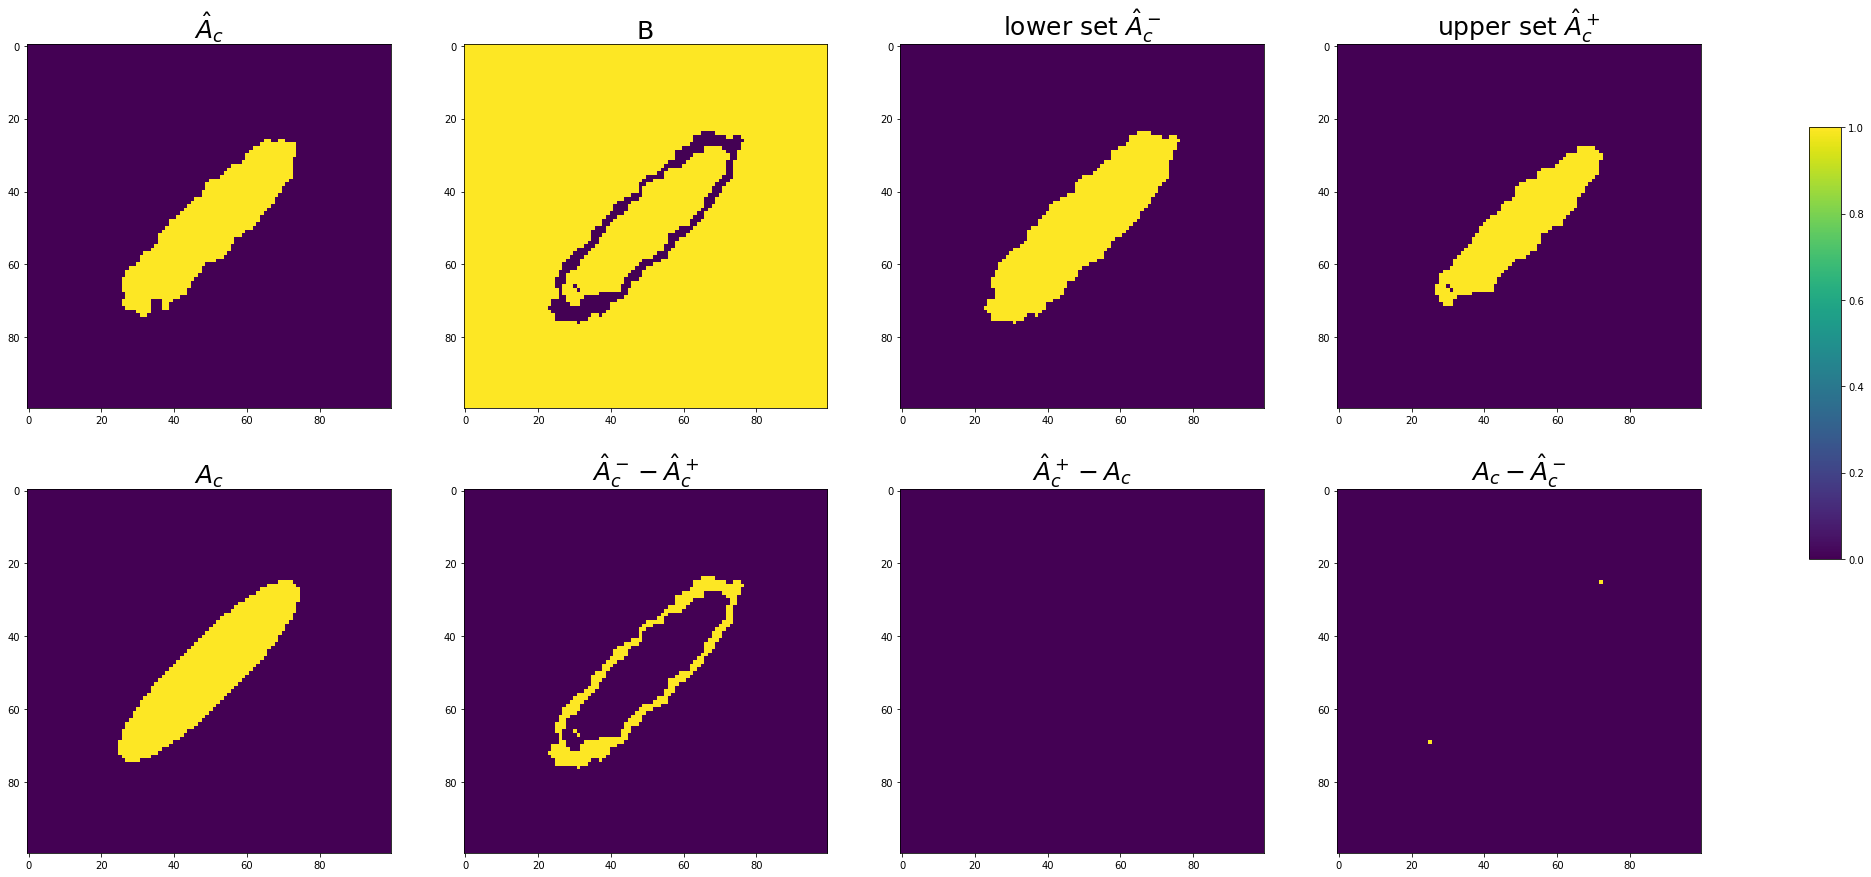

In [126]:
threshold = 2
alpha = 0.05


data =ellipse_100_smth
mu = mu_ellipse_100
Ac = mu >= threshold


data_tstat = mvtstat(data - threshold)
data_dim = data.shape
nsubj = data_dim[0]
Achat = data_tstat >= 0
Achat_C = data_tstat < 0


# a two sided test
pvals = 2*(1 - scipy.stats.t.cdf(abs(data_tstat), df=nsubj - 1))
rejection_ind, _, _ = fdr_BH(pvals, alpha)
outer_set_2 = 1- Achat_C * rejection_ind
inner_set_2 = Achat*rejection_ind
  
outsubinn = np.maximum(outer_set_2 - inner_set_2, 0)
FN_upp = np.maximum(inner_set_2 - Ac, 0)
FN_low = np.maximum(Ac-outer_set_2, 0)
fig, axs = plt.subplots(2, 4, figsize=(30, 15))

_min, _max = 0,1

im = axs[0,0].imshow(Achat, vmin = _min, vmax = _max)
axs[0,0].set_title("$\hat{A}_c$", fontsize = 25)
im = axs[0,1].imshow(rejection_ind, vmin = _min, vmax = _max)
axs[0,1].set_title("B", fontsize = 25)
im = axs[0,2].imshow(outer_set_2, vmin = _min, vmax = _max)
axs[0,2].set_title("lower set $\hat{A}_c^-$", fontsize = 25)
im = axs[0,3].imshow(inner_set_2, vmin = _min, vmax = _max)
axs[0,3].set_title("upper set $\hat{A}_c^+$", fontsize = 25)
im = axs[1,0].imshow(Ac, vmin = _min, vmax = _max)
axs[1,0].set_title("$A_c$", fontsize = 25)
im = axs[1,1].imshow(outsubinn)
axs[1,1].set_title("$\hat{A}_c^- - \hat{A}_c^+$", fontsize = 25)

im = axs[1,2].imshow(FN_upp, vmin = _min, vmax = _max)
axs[1,2].set_title("$\hat{A}_c^+ - A_c$", fontsize = 25)
im = axs[1,3].imshow(FN_low, vmin = _min, vmax = _max)
axs[1,3].set_title("$A_c - \hat{A}_c^- $", fontsize = 25)



cbar_ax = fig.add_axes([0.95, 0.4, 0.015, 0.4])
fig.colorbar(im, cax=cbar_ax, cmap='RdPu')
plt.show()


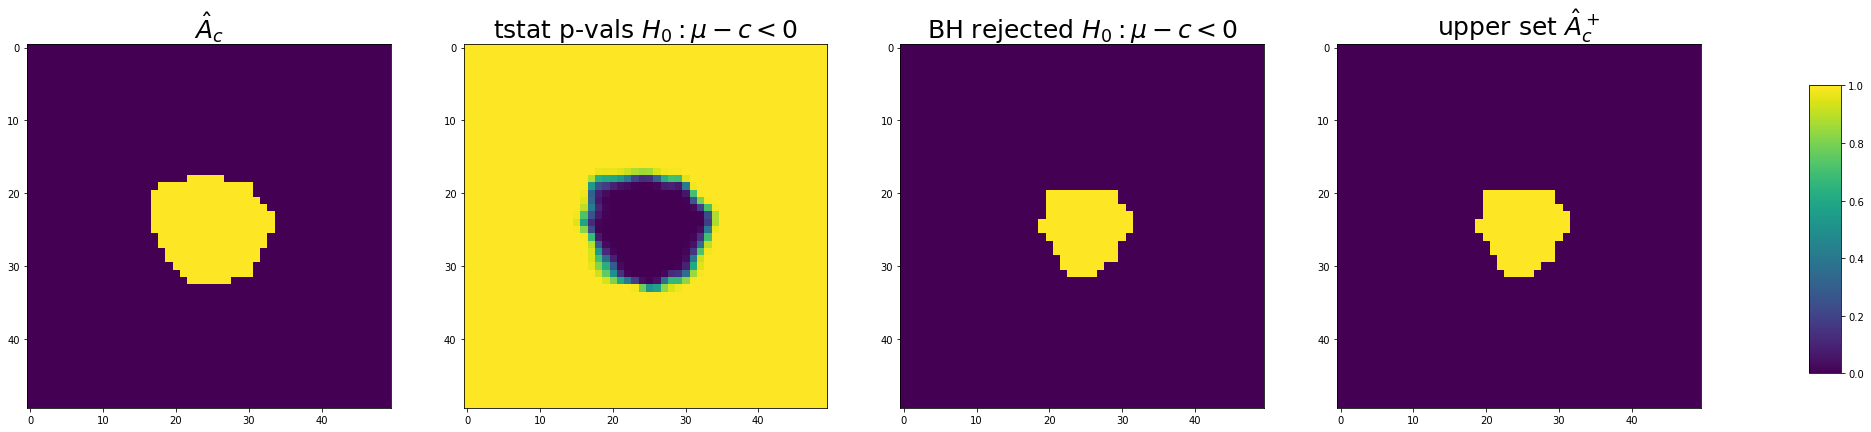

In [ ]:
# one-sided for upper set (H_0: mu < c)
data = circular_s_smth
threshold = 2
alpha = 0.05

data_tstat = mvtstat(data - threshold)
data_dim = data.shape

nsubj = data_dim[0]
Achat = data_tstat >= 0
Achat_C = data_tstat < 0


pvals = (1 - scipy.stats.t.cdf(data_tstat, df=nsubj - 1))
rejection_ind, _, _ = fdr_BH(pvals, alpha)
inner_set_1 = Achat*rejection_ind
  


fig, axs = plt.subplots(1, 4, figsize=(30, 20))

_min, _max = 0,1

im = axs[0].imshow(Achat)
axs[0].set_title("$\hat{A}_c$", fontsize = 25)

im = axs[1].imshow(pvals, vmin = _min, vmax = _max)
axs[1].set_title("tstat p-vals $H_0: \mu-c < 0$", fontsize = 25)


im = axs[2].imshow(rejection_ind, vmin = _min, vmax = _max)
axs[2].set_title("BH rejected $H_0: \mu-c < 0$", fontsize = 25)

im = axs[3].imshow(inner_set_1, vmin = _min, vmax = _max)
axs[3].set_title("upper set $\hat{A}_c^+$", fontsize = 25)


cbar_ax = fig.add_axes([0.95, 0.4, 0.015, 0.2])
fig.colorbar(im, cax=cbar_ax, cmap='Greys')

plt.show()



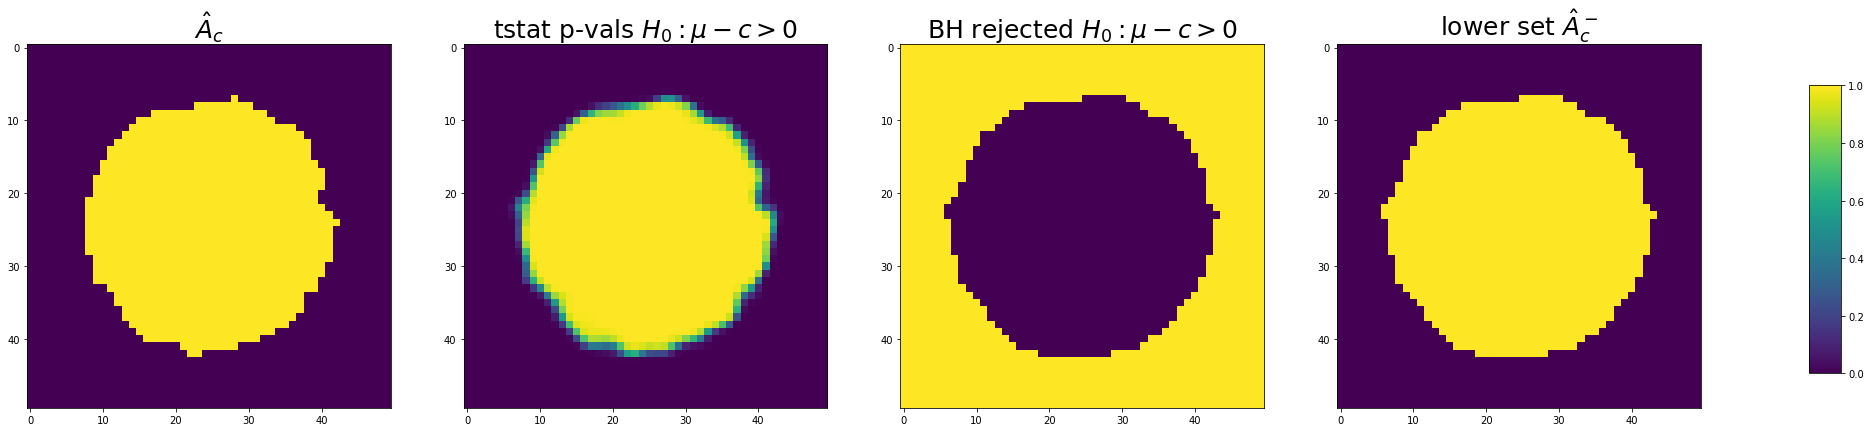

In [ ]:
# one-sided for lower set (H_0: mu > c) 
data = circular_l_smth
threshold = 2
alpha = 0.05

data_tstat = mvtstat(data - threshold)
data_dim = data.shape

nsubj = data_dim[0]
Achat = data_tstat >= 0
Achat_C = data_tstat < 0

pvals = (scipy.stats.t.cdf(data_tstat, df=nsubj - 1))
rejection_ind, _, _ = fdr_BH(pvals, alpha)
outer_set_1 = (1 - Achat_C*rejection_ind) #using Ac- formula

fig, axs = plt.subplots(1, 4, figsize=(30, 20))

_min, _max = 0,1

im = axs[0].imshow(Achat)
axs[0].set_title("$\hat{A}_c$", fontsize = 25)

im = axs[1].imshow(pvals, vmin = _min, vmax = _max)
axs[1].set_title("tstat p-vals $H_0: \mu-c > 0$", fontsize = 25)


im = axs[2].imshow(rejection_ind, vmin = _min, vmax = _max)
axs[2].set_title("BH rejected $H_0: \mu-c > 0$", fontsize = 25)

im = axs[3].imshow(outer_set_1, vmin = _min, vmax = _max)
axs[3].set_title("lower set $\hat{A}_c^-$", fontsize = 25)


cbar_ax = fig.add_axes([0.95, 0.4, 0.015, 0.2])
fig.colorbar(im, cax=cbar_ax, cmap='Greys')

plt.show()



## Confidence Sets
Now we look at $\hat{A}_c^+ + \hat{A}_c^-$ + $A_c$

### BH

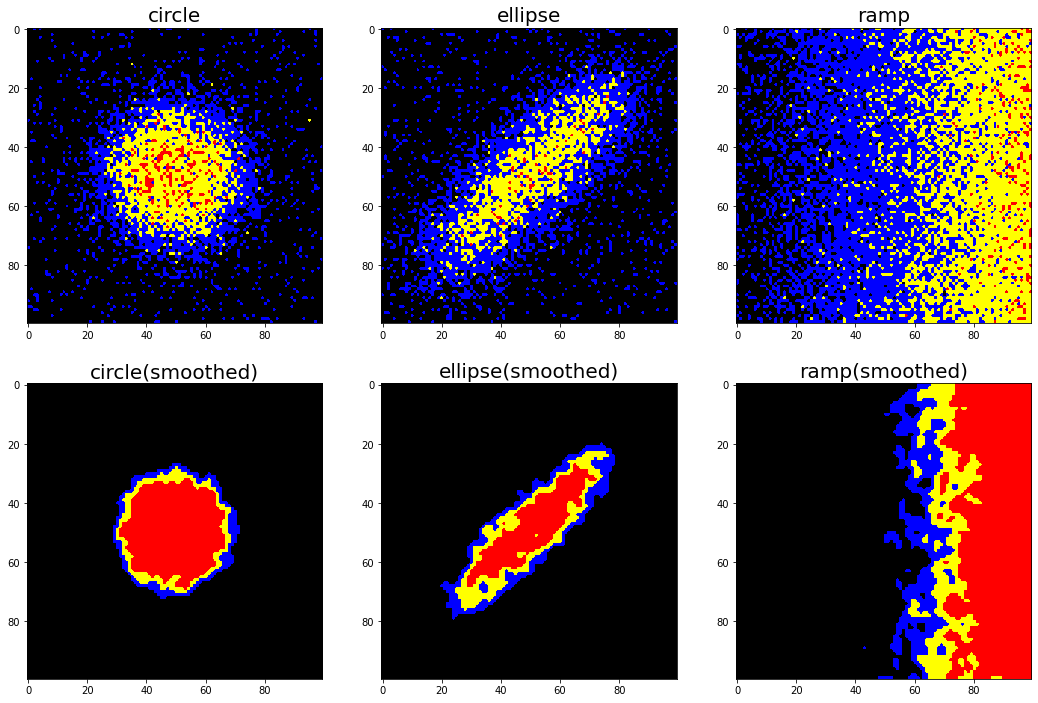

In [3]:
conf_plot_agg(threshold=2, std=5, tail="two", method="BH", _min=0, _max=3, fontsize=20, figsize = (18,12))

### Adaptive

*   Used k=2, $\alpha_0 = 0.05/4$, $\alpha_1 = 0.05/2$

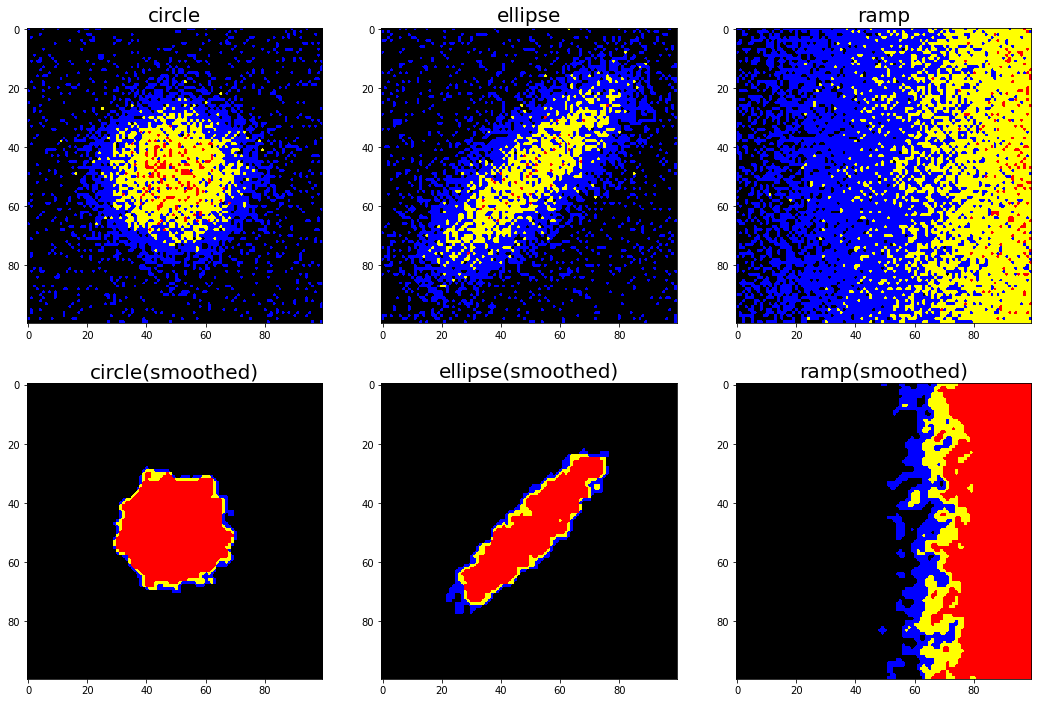

In [4]:
conf_plot_agg(threshold=2, std=5, tail="two", method="adaptive", _min=0, _max=3, fontsize=20, figsize = (18,12))

# FDR Simulations

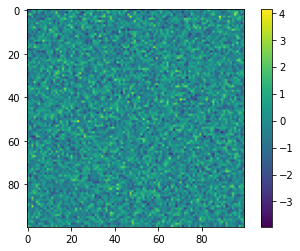

100*100 no signal ERR: 0.0


In [151]:
#sanity check
dim_l = (80,100,100)
no_signal = np.random.randn(*dim_l)
plt.imshow(no_signal[0,:,:])
plt.colorbar()
plt.show()

nosig_ERR1 = []
num_sim=5
for i in np.arange(num_sim):
  nosig_ERR1.append(fdr_error_check(dim=(80,100,100), c=0, method="BH", shape = 'noise', std=3, alpha=0.05, tail="two"))

print("100*100 no signal ERR:", np.mean(nosig_ERR1))


## 1) FDR: $E\frac{| (\hat{A}_c^+ - A_c) 𝖴 ( A_c - \hat{A}_c^-) |} {|(\hat{A}_c^- - \hat{A}_c^+)^C |  }$



In [25]:
simnum = 10
cmarg = 0.1
std=  5
BH50_fdr, BH100_fdr = error_check_sim(mode = "fdr", sim_num=simnum, method="BH", c=(1,2,3), c_marg=cmarg, std=std, tail="two", alpha=0.05, alpha0=0.05/4, alpha1=0.05/2)
AD50_fdr, AD100_fdr = error_check_sim(mode = "fdr", sim_num=simnum, method="adaptive", c=(1,2,3), c_marg=cmarg, std=std, tail="two", alpha=0.05, alpha0=0.05/4, alpha1=0.05/2)

print("------------------------------------------------------------------------- BH FDR ----------------------------------------------------------------------------")
print("----------------------------------------------------------------------imagesize:(50*50)----------------------------------------------------------------------")
print(tabulate(BH50_fdr, headers='keys'))
print()
print("----------------------------------------------------------------------imagesize:(100*100)--------------------------------------------------------------------")
print(tabulate(BH100_fdr, headers='keys'))

print("----------------------------------------------------------------------- Adaptive FDR ------------------------------------------------------------------------")
print("----------------------------------------------------------------------imagesize:(50*50)----------------------------------------------------------------------")
print(tabulate(AD50_fdr, headers='keys'))
print()
print("----------------------------------------------------------------------imagesize:(100*100)--------------------------------------------------------------------")
print(tabulate(AD100_fdr, headers='keys'))



------------------------------------------------------------------BH FDR ERR(noise~N(0,5^2))------------------------------------------------------------------
----------------------------------------------------------------------imagesize:(50*50)----------------------------------------------------------------------
threshold      circle    circle(smth)    alpha*m0/m(circle)    ellipse    ellipse(smth)    alpha*m0/m(ellipse)    ramp    ramp(smth)    alpha*m0/m(ramp)
-----------  --------  --------------  --------------------  ---------  ---------------  ---------------------  ------  ------------  ------------------
c=1            0.0018          0.0003               0.00136     0.0021           0.001                 0.00176  0.0036        0.0012               0.003
c=2            0.0012          0.0007               0.0012      0.0012           0.0004                0.00148  0.004         0.0013               0.003
c=3            0.0004          0.0003               0.0012      0.0001 

## 2) FNDR: $E\frac{| (A_c - \hat{A}_c^+) 𝖴 ( - \hat{A}_c^ - A_c) |} { | \hat{A}_c^- - \hat{A}_c^+ |  }$





In [11]:
BH50_fndr, BH100_fndr = error_check_sim(mode = "fndr", sim_num=10, method="BH", c=(1,2,3), c_marg=cmarg, std=std, tail="two", alpha=0.05, alpha0=0.05/4, alpha1=0.05/2)
AD50_fndr, AD100_fndr = error_check_sim(mode = "fndr", sim_num=simnum, method="adaptive", c=(1,2,3), c_marg=cmarg, std=std, tail="two", alpha=0.05, alpha0=0.05/4, alpha1=0.05/2)


print("------------------------------------------------------------------BH FNDR ERR(noise~N(0,5^2))------------------------------------------------------------------")
print("----------------------------------------------------------------------imagesize:(50*50)----------------------------------------------------------------------")
print(tabulate(BH50_fndr, headers='keys'))
print()
print("----------------------------------------------------------------------imagesize:(100*100)--------------------------------------------------------------------")
print(tabulate(BH100_fndr, headers='keys'))
print("----------------------------------------------------------------------- Adaptive FNDR -----------------------------------------------------------------------")
print("----------------------------------------------------------------------imagesize:(50*50)----------------------------------------------------------------------")
print(tabulate(AD50_fndr, headers='keys'))
print()
print("----------------------------------------------------------------------imagesize:(100*100)--------------------------------------------------------------------")
print(tabulate(AD100_fndr, headers='keys'))



/usr/local/lib/python3.9/dist-packages/confidenceset/functions.py:357: RuntimeWarning: invalid value encountered in long_scalars
  ERR = numer / denom


------------------------------------------------------------------BH FDR ERR(noise~N(0,5^2))------------------------------------------------------------------
----------------------------------------------------------------------imagesize:(50*50)----------------------------------------------------------------------
threshold      circle    circle(smth)    alpha*m0/m(circle)    ellipse    ellipse(smth)    alpha*m0/m(ellipse)    ramp    ramp(smth)    alpha*m0/m(ramp)
-----------  --------  --------------  --------------------  ---------  ---------------  ---------------------  ------  ------------  ------------------
c=1            1.0005          1.0031               0.00136     1.0003           1.0041                0.00176  1.0012        1.0035               0.003
c=2            1.0031          1.0045               0.0012      1.0028           1.0031                0.00148  1.001         1.0023               0.003
c=3            1.0034          1.0061               0.0012      1.0003 

<ipython-input-6-8912a6a8948f>:303: RuntimeWarning: Mean of empty slice
  ERR2.update({n: np.round(np.nanmean(ERR2[n], axis=1), 4) for n in ERR2_key_calc})


## 3) power

In [12]:
BH50_power, BH100_power = error_check_sim(mode = "power", sim_num=simnum, method="BH", c=(1,2,3), c_marg=cmarg, std=std, tail="two", alpha=0.05, alpha0=0.05/4, alpha1=0.05/2)
AD50_power, AD100_power = error_check_sim(mode = "power", sim_num=simnum, method="adaptive", c=(1,2,3), c_marg=cmarg, std=std, tail="two", alpha=0.05, alpha0=0.05/4, alpha1=0.05/2)

print("----------------------------------------------------------------------- BH POWER -----------------------------------------------------------------------")
print("----------------------------------------------------------------------imagesize:(50*50)----------------------------------------------------------------------")
print(tabulate(BH50_power, headers='keys'))
print()
print("----------------------------------------------------------------------imagesize:(100*100)--------------------------------------------------------------------")
print(tabulate(BH100_power, headers='keys'))
print("----------------------------------------------------------------------- Adaptive POWER -----------------------------------------------------------------------")
print("----------------------------------------------------------------------imagesize:(50*50)----------------------------------------------------------------------")
print(tabulate(AD50_power, headers='keys'))
print()
print("----------------------------------------------------------------------imagesize:(100*100)--------------------------------------------------------------------")
print(tabulate(AD100_power, headers='keys'))

UnboundLocalError: ignored